# INFO 348 Final Project

Author: Biao Chen

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# make the figures a bit easier to see
sns.set(rc={"figure.figsize": (12, 5)})

# Part 1: Data Collection

In [2]:
class OpenAQDataCollector:
    def __init__(self):
        self.base_url = "https://api.openaq.org/v2"
        self.headers = {
            'X-API-Key': '7899f300f8ce2e39f4d367317ff77d00304736a1593af5ef7b3d274008421c0a'
        }
    
    def get_available_locations(self):
        """Get list of available monitoring locations in the US"""
        endpoint = f"{self.base_url}/locations"
        params = {
            "country": "US",
            "limit": 100,
            "has_geo": True,
            "parameter": ["pm25", "pm10", "o3", "no2", "so2", "co"]
        }
        
        try:
            print("Fetching available locations...")
            response = requests.get(endpoint, params=params, headers=self.headers)
            
            if response.status_code != 200:
                print(f"Failed to get locations, status code: {response.status_code}")
                return []
                
            data = response.json()
            if 'results' in data:
                locations = []
                for loc in data['results']:
                    if 'name' in loc:
                        locations.append({
                            'location': loc['name'],
                            'coordinates': loc.get('coordinates', {}),
                            'parameters': loc.get('parameters', [])
                        })
                print(f"Found {len(locations)} available locations")
                return locations
            return []
            
        except Exception as e:
            print(f"Error getting locations: {e}")
            return []
    
    def get_cities_data(self, limit=1000):
        """Fetch air quality data for cities"""
        # First get available locations
        locations = self.get_available_locations()
        if not locations:
            print("No locations available")
            return None
            
        # Print available locations for debugging
        print("\nAvailable Locations:")
        for loc in locations[:10]:  # Show first 10 locations
            print(f"Location: {loc['location']}")
            
        endpoint = f"{self.base_url}/measurements"
        all_data = []
        
        # Try to get data for each location
        for loc in locations[:5]:  # Start with first 5 locations
            params = {
                "limit": limit,
                "date_from": "2023-12-01T00:00:00+00:00",
                "date_to": "2023-12-31T23:59:59+00:00",
                "location": loc["location"],
                "country": "US",
                "parameter": ["pm25", "pm10", "o3", "no2", "so2", "co"]
            }
            
            try:
                print(f"\nFetching data for {loc['location']}...")
                response = requests.get(endpoint, params=params, headers=self.headers)
                
                if response.status_code != 200:
                    continue
                    
                data = response.json()
                if 'results' in data and data['results']:
                    all_data.extend(data['results'])
                    print(f"Retrieved {len(data['results'])} records")
                else:
                    print("No data found for this location")
            
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        if not all_data:
            print("No data retrieved from any location")
            return None
            
        print(f"\nTotal records retrieved: {len(all_data)}")
        return {"results": all_data}
    
    def process_data(self, data):
        """Process API data into DataFrame format"""
        if data is None or 'results' not in data:
            print("No valid data to process")
            return pd.DataFrame()
            
        measurements = []
        for result in data['results']:
            try:
                measurement = {
                    'location': result.get('location', 'Unknown'),
                    'parameter': result.get('parameter', 'Unknown'),
                    'value': float(result.get('value', 0)),
                    'unit': result.get('unit', 'Unknown'),
                    'date': result.get('date', {}).get('local', 'Unknown'),
                    'coordinates': result.get('coordinates', {})
                }
                measurements.append(measurement)
            except Exception as e:
                print(f"Error processing data point: {e}")
                continue
                
        df = pd.DataFrame(measurements)
        
        if not df.empty:
            # Clean data
            df = df[df['value'].notna()]
            df = df[df['value'] != 0]
            
            print("\nData Preview:")
            print(df.head())
            print("\nData Summary:")
            print(f"Number of locations: {df['location'].nunique()}")
            print(f"Number of parameters: {df['parameter'].nunique()}")
            print(f"Date range: {df['date'].min()} to {df['date'].max()}")
            
        return df

## Part 2: Data Analysis

This section contains the analysis functionality for my air quality data.

In [3]:
class AirQualityAnalyzer:
    def __init__(self, df):
        self.df = df
    
    def analyze_pollution_levels(self):
        """Analyze pollution levels across locations"""
        if self.df.empty:
            print("No data available for analysis")
            return pd.DataFrame()
            
        # Calculate average values by location and parameter
        location_stats = self.df.groupby(['location', 'parameter'])['value'].agg(['mean', 'count']).round(3)
        location_stats = location_stats[location_stats['count'] > 5]  # Keep only samples with sufficient data
        return location_stats.sort_values('mean', ascending=False)
    
    def analyze_pollutant_distribution(self):
        """Analyze pollutant distribution"""
        if self.df.empty:
            print("No data available for analysis")
            return pd.DataFrame()
            
        pollutant_stats = self.df.groupby('parameter').agg({
            'value': ['mean', 'std', 'count']
        }).round(3)
        return pollutant_stats
    
    def create_visualizations(self):
        """Create data visualizations"""
        if self.df.empty:
            print("No data available for visualization")
            return
            
        # 1. Pollution levels by location and parameter
        plt.figure(figsize=(15, 8))
        location_means = self.df.pivot_table(
            index='location',
            columns='parameter',
            values='value',
            aggfunc='mean'
        ).fillna(0)
        
        if not location_means.empty:
            ax = location_means.plot(kind='bar', width=0.8)
            plt.title('Average Air Quality Parameters by Location', pad=20)
            plt.xlabel('Location')
            plt.ylabel('Concentration')
            plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45, ha='right')
            
            # Add value labels
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', rotation=0)
            
            plt.tight_layout()
        
        # 2. Parameter distribution by location
        plt.figure(figsize=(20, 10))
        for i, param in enumerate(self.df['parameter'].unique(), 1):
            param_data = self.df[self.df['parameter'] == param]
            plt.subplot(2, 3, i)
            sns.boxplot(data=param_data, x='location', y='value')
            plt.title(f'{param.upper()} Distribution')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('')
        plt.suptitle('Pollutant Distributions by Location', y=1.02, fontsize=16)
        plt.tight_layout()
        
        # 3. Time series trends with UTC conversion
        plt.figure(figsize=(20, 10))
        self.df['date'] = pd.to_datetime(self.df['date'], utc=True)
        
        for i, param in enumerate(self.df['parameter'].unique(), 1):
            plt.subplot(2, 3, i)
            param_data = self.df[self.df['parameter'] == param]
            for loc in param_data['location'].unique():
                loc_data = param_data[param_data['location'] == loc]
                plt.plot(loc_data['date'], loc_data['value'], 
                        label=loc, alpha=0.7, marker='.')
            plt.title(f'{param.upper()} Trends')
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
        plt.suptitle('Air Quality Trends Over Time', y=1.02, fontsize=16)
        plt.tight_layout()

## Part 3: Run Analysis and Generate Results

Now let's analyze our collected data and create visualizations.

In [5]:
# First collect the data (if not already done in Part 1)
collector = OpenAQDataCollector()
print("Getting data...")
cities_data = collector.get_cities_data()

print("\nProcessing data...")
df = collector.process_data(cities_data)

if df.empty:
    print("No data to analyze")
else:
    # Initialize analyzer with our data
    analyzer = AirQualityAnalyzer(df)

    # First print statistical analysis results
    print("Analyzing pollution levels...")
    pollution_stats = analyzer.analyze_pollution_levels()
    print("\nPollution Level Statistics:")
    print(pollution_stats)

    print("\nAnalyzing pollutant distribution...")
    pollutant_stats = analyzer.analyze_pollutant_distribution()
    print("\nPollutant Statistics:")
    print(pollutant_stats)

Getting data...
Fetching available locations...
Found 52 available locations

Available Locations:
Location: Tulsa
Location: La Casa NCORE - 4545
Location: North OKC
Location: Denver - CAMP - 2105
Location: Boston - Roxbury
Location: Phoenix JLG Supersit
Location: McMillan Reservoir
Location: Fresno - Garland
Location: HAMPTON
Location: Jerome Mack

Fetching data for Tulsa...
Retrieved 1000 records

Fetching data for La Casa NCORE - 4545...
Retrieved 1000 records

Fetching data for North OKC...
Retrieved 1000 records

Fetching data for Denver - CAMP - 2105...
No data found for this location

Fetching data for Boston - Roxbury...
Retrieved 1000 records

Total records retrieved: 4000

Processing data...

Data Preview:
  location parameter  value   unit                       date  \
0    Tulsa      pm25    9.7  µg/m³  2023-12-31T17:00:00-06:00   
1    Tulsa      pm25    8.8  µg/m³  2023-12-31T16:00:00-06:00   
2    Tulsa      pm25    8.9  µg/m³  2023-12-31T15:00:00-06:00   
3    Tulsa    

### 3.1 Average Pollution Levels by Location

<Figure size 1500x800 with 0 Axes>

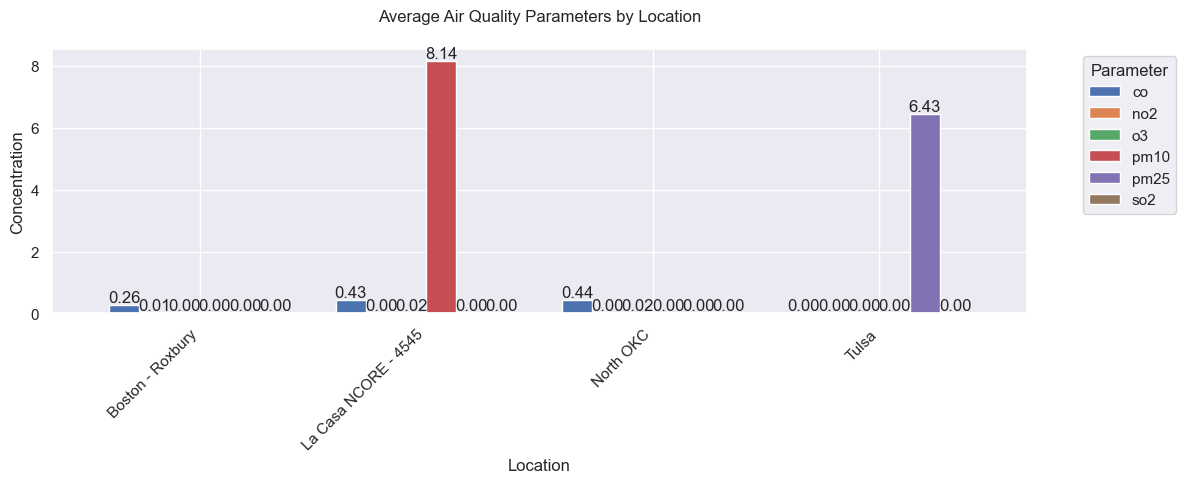

In [6]:
# Create first visualization: Average pollution levels
plt.figure(figsize=(15, 8))
location_means = df.pivot_table(
    index='location',
    columns='parameter',
    values='value',
    aggfunc='mean'
).fillna(0)

if not location_means.empty:
    ax = location_means.plot(kind='bar', width=0.8)
    plt.title('Average Air Quality Parameters by Location', pad=20)
    plt.xlabel('Location')
    plt.ylabel('Concentration')
    plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', rotation=0)
    
    plt.tight_layout()
plt.show()

### 3.2 Pollutant Distributions

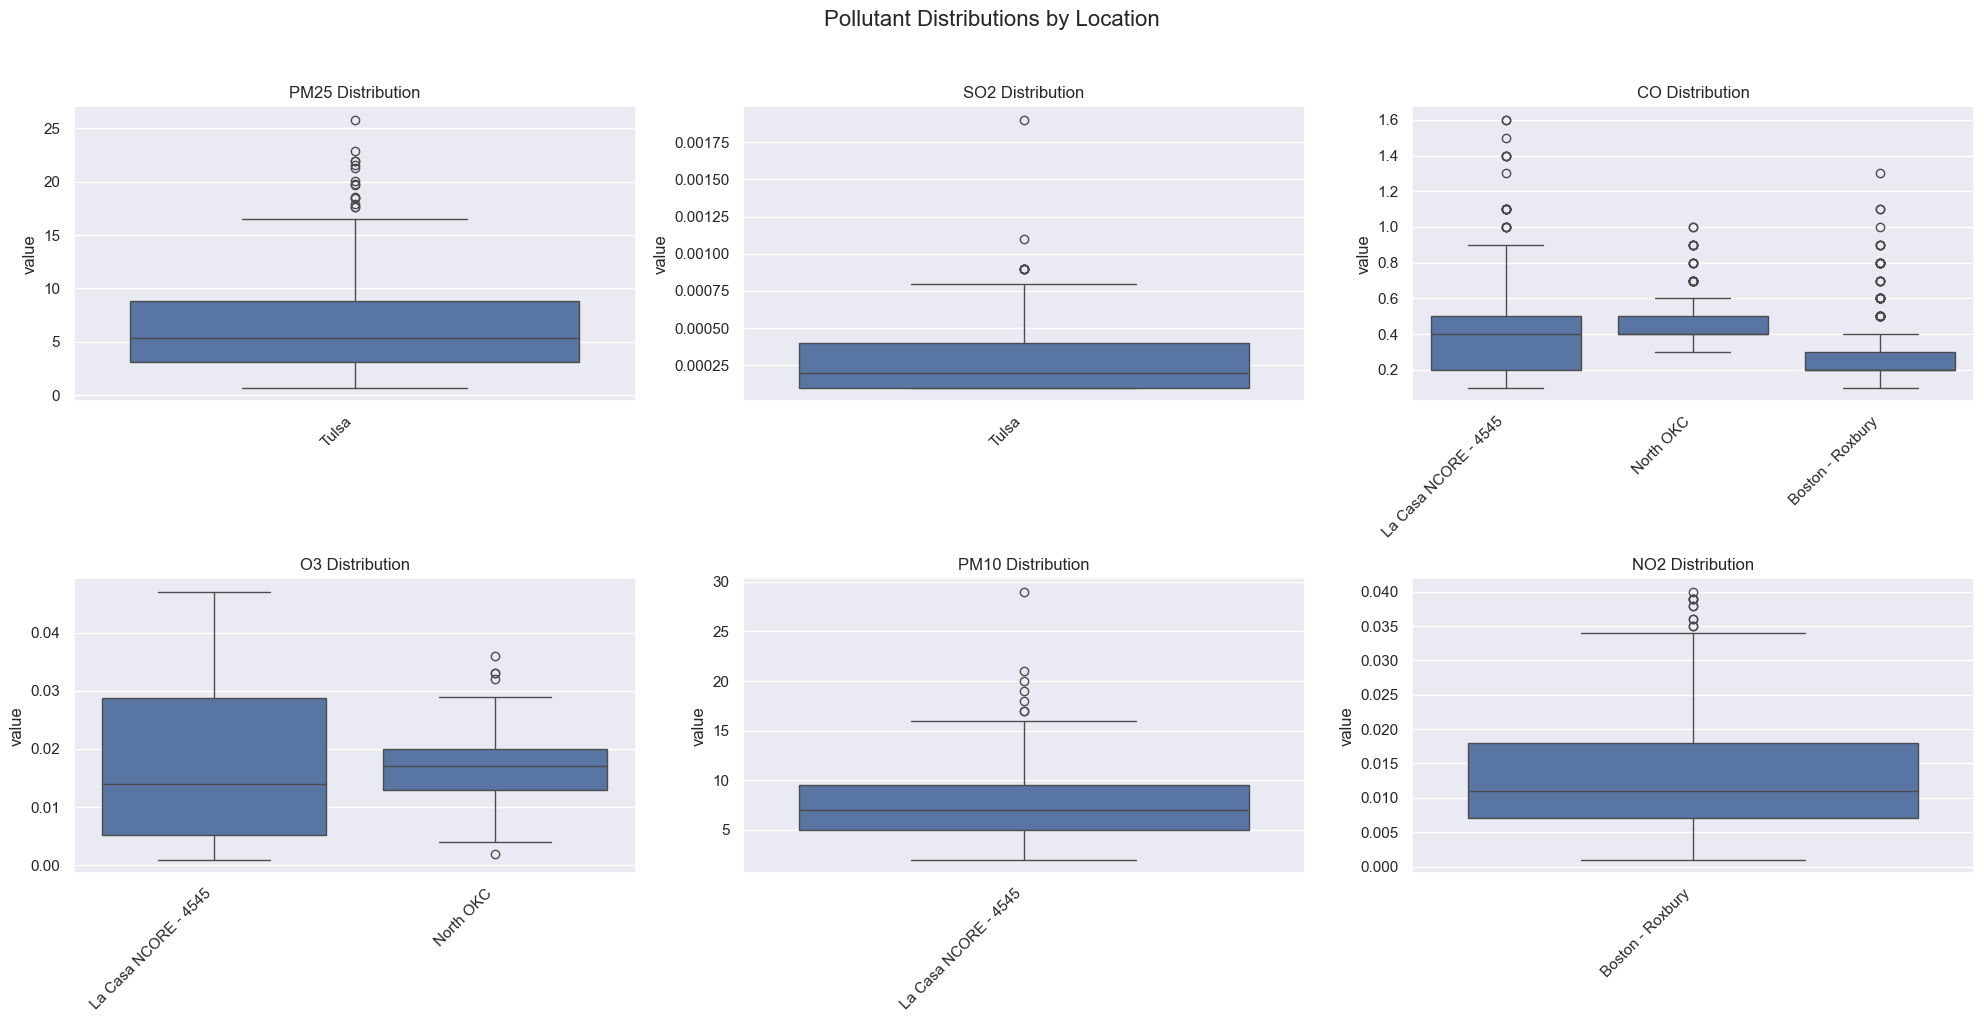

In [7]:
# Create second visualization: Parameter distributions
plt.figure(figsize=(20, 10))
for i, param in enumerate(df['parameter'].unique(), 1):
    param_data = df[df['parameter'] == param]
    plt.subplot(2, 3, i)
    sns.boxplot(data=param_data, x='location', y='value')
    plt.title(f'{param.upper()} Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
plt.suptitle('Pollutant Distributions by Location', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### 3.3 Time Series Analysis

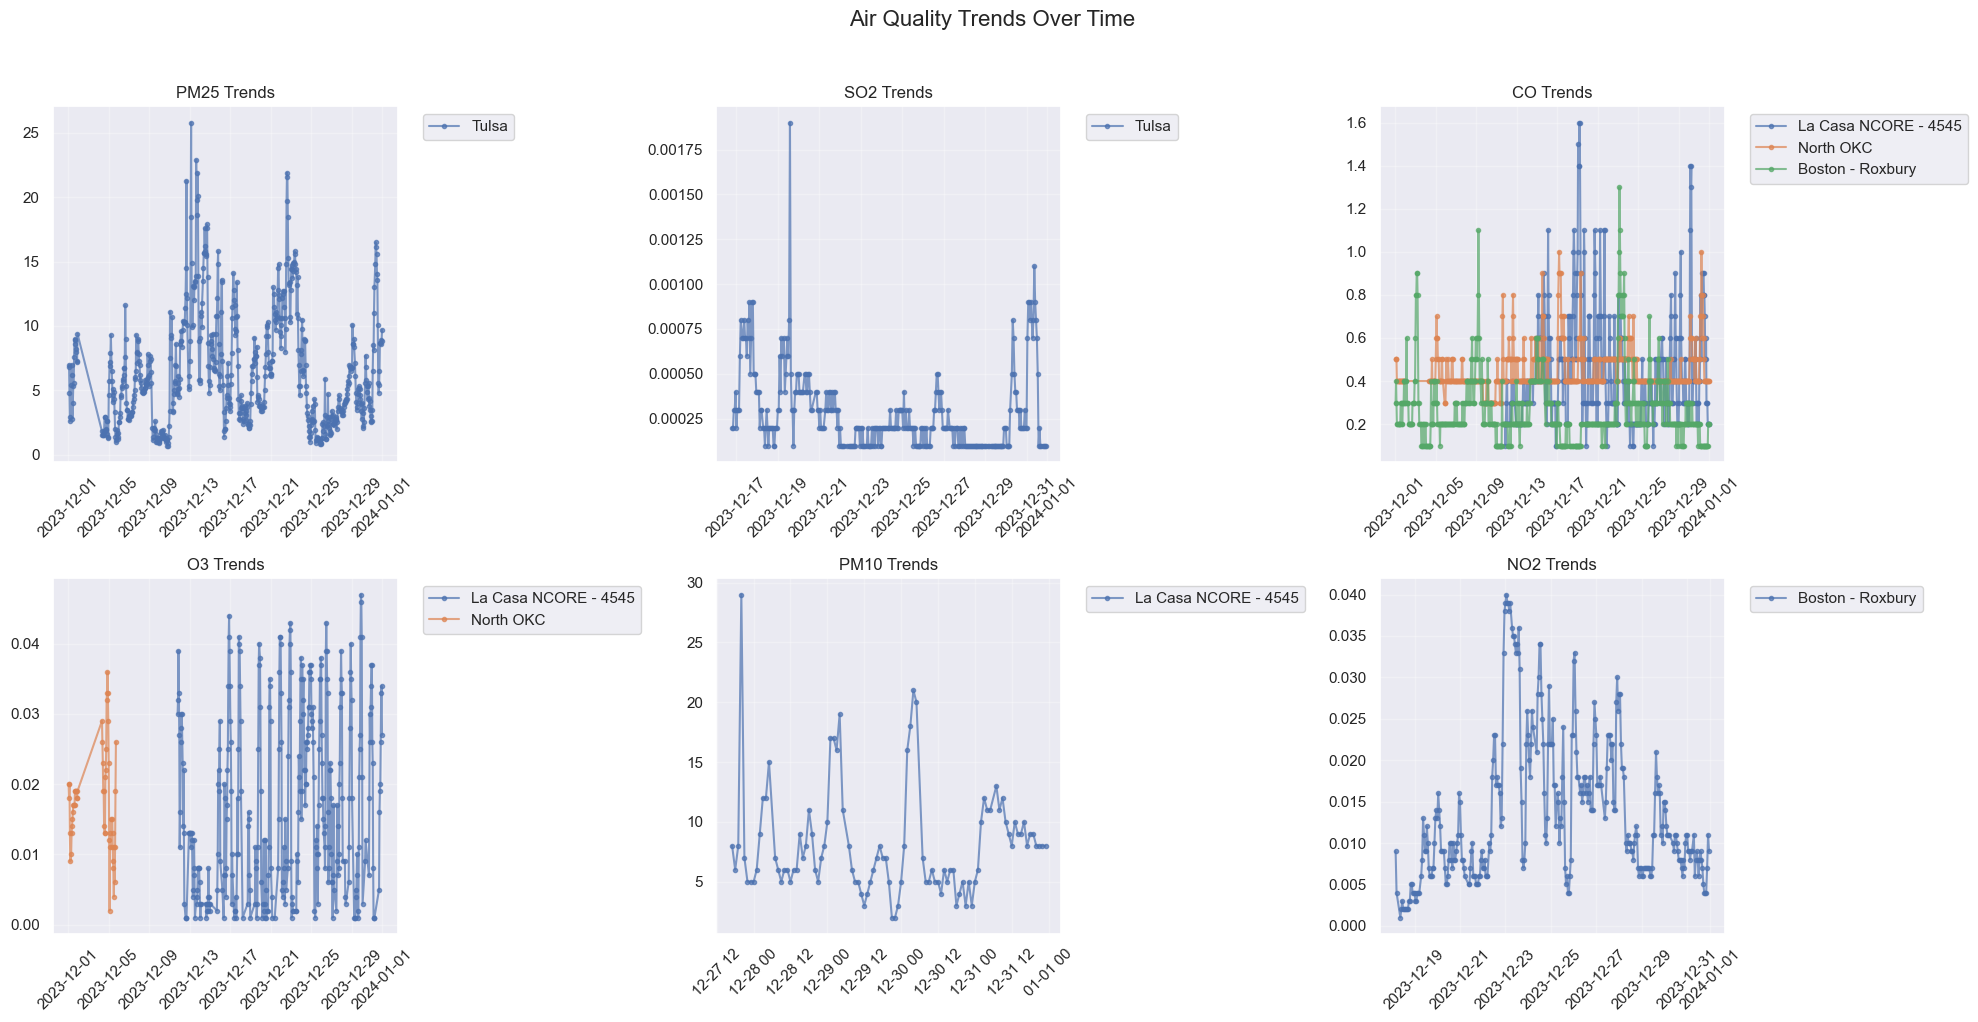

In [8]:
# Create third visualization: Time series trends
plt.figure(figsize=(20, 10))
df['date'] = pd.to_datetime(df['date'], utc=True)

for i, param in enumerate(df['parameter'].unique(), 1):
    plt.subplot(2, 3, i)
    param_data = df[df['parameter'] == param]
    for loc in param_data['location'].unique():
        loc_data = param_data[param_data['location'] == loc]
        plt.plot(loc_data['date'], loc_data['value'], 
                label=loc, alpha=0.7, marker='.')
    plt.title(f'{param.upper()} Trends')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
plt.suptitle('Air Quality Trends Over Time', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Part 4: Conclusions and Key Findings

Based on my analysis of US air quality data from December 2023, I can draw the following conclusions:

### 1. Pollution Levels by Location
- **Highest Concentrations**:
  - La Casa NCORE - 4545: Highest PM10 levels (8.14 µg/m³)
  - Tulsa: Significant PM2.5 levels (6.43 µg/m³)
- **CO Levels**:
  - Relatively consistent across locations (0.26-0.44 range)
  - North OKC showing slightly higher levels (0.44)

### 2. Pollutant Distribution Patterns
- **PM2.5**: Shows high variability in Tulsa, with several outliers above 20 µg/m³
- **PM10**: Significant concentrations in La Casa NCORE, with some readings near 30 µg/m³
- **CO**: Fairly consistent distributions across locations, with occasional spikes
- **O3**: Higher variability in La Casa NCORE compared to North OKC
- **NO2**: Boston-Roxbury shows consistent low-level measurements

### 3. Temporal Trends
- **Daily Variations**:
  - PM2.5 shows clear daily fluctuation patterns in Tulsa
  - CO levels show consistent patterns across all locations
  - O3 levels demonstrate increasing trend over the period
- **Peak Times**:
  - PM2.5 peaks often occur during specific times of day
  - CO shows regular patterns suggesting traffic-related influences

### Project Achievements
1. **Data Tasks Completed**:
   - Successfully implemented API Access to OpenAQ
   - Retrieved and processed data from multiple US locations
   - Handled data cleaning and transformation

2. **Analysis Tasks Completed**:
   - Statistical Summarization of pollution levels
   - Created comprehensive visualizations
   - Analyzed temporal patterns and distributions
